# 필기체 인식기 개발
## 손글씨 데이터 
Class : 0~9(10개)

크기 : 가로 28, 세로 28 

채널 : 1 channel(Gray 이미지) 

학습 데이터 수 : 60000장 

평가 데이터 수 : 10000장


In [12]:
import matplotlib.pyplot as plt  # 그래프 그리는 도구
import torchvision   # 데이터 패키지들

mnist = torchvision.datasets.MNIST(root = './data', train = True, download = True )
# root 저장위치, '.'은 현재 위치를 의미함, train 데이터도 가져올거다. 없다면 download도 할거임
# data폴더 생성되고 저장됨

torch.Size([60000, 28, 28])
torch.Size([60000])
tensor(2)


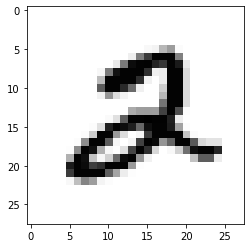

In [13]:
print(mnist.data.size())  # 전체 데이터 : 60000개, 크기 28x28 
print(mnist.targets.size())

# targets 숫자 바꿔서 여러개 확인해 볼 수 있음 
print(mnist.targets[5])  # 60000개 중에서 5번째 데이터의 값은 2임 

plt.imshow(
    mnist.data[5], 
    cmap = 'Greys',
    interpolation = 'nearest', # 280x280 으로 만들면 어떤 식으로 만들어서 보여줄거야
    )
plt.show()

In [14]:
# 관련 패키지 import 
import torch 
import torch.nn as nn  # forward, backward 구현해둔 패키지
import torch.nn.functional as F  # nn에 있는 함수를 의미(설명 추후 진행)
import torchvision  # 데이터 패키지들
import torchvision.transforms as transforms # 이미지가 28x28임 네트워크는 큰 이미지를 보고 판단하는게 좋음
# 숫자 리스트를 Tensor 자로형으로 바꿔주는 역할, 이미지를 늘려주기도 하고, 여러 변환과정을 담고있는 패키지
import matplotlib.pyplot as plt # 그림 그리는 것이다.

In [15]:
# Device configuration, gpu 사용 가능한 경우 device를 gpu로 설정하고 사용 불가능하면 cpu로 설정
# 항상 이대로 사용하면 됨 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device # cuda이면 gpu 사용할 수 있구나 확인 가능

device(type='cuda')

In [16]:
# Hyper-parameters    # 사용자가 직접 모델에게 변경해주는 변수 
input_size = 784  # 28*28 # 수직으로 세우는 것
hidden_size = 500  # 퍼셉트론이 한층에 500개 있음 
num_classes = 10  # output 10개 (0~9)까지 있으므로
num_epochs = 5  # 5번반복 
batch_size = 100  # 하나의 batch당 100개의 샘플
learning_rate = 0.001 

In [17]:
# 파이토치에서 제공하는 MNIST dataset
# transform 숫자덩어리를 텐서형으로 바꿀거야
train_dataset = torchvision.datasets.MNIST(root = './data', train = True,
                                           transform = transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.MNIST(root = './data', train = False,
                                          transform = transforms.ToTensor())

In [20]:
# 배치 단위로 데이터를 처리해주는 Data loader 
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle = True) # 600개의 iteration중 랜덤으로 뽑는 것

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, 
                                     batch_size = batch_size, 
                                     shuffle = False) # 테스트 데이터 이므로 랜덤일 필요 없음

In [21]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, num_classes)
  
  def forward(self,x):
    out = F.relu(self.fc1(x))  # F : Forward 과정에서 쓸 수 있음
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

In [22]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)  # 모델을 지정한 device로 올려줌

In [24]:
criterion = nn.CrossEntropyLoss()  # criterion = Loss, CE
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # optimizer로 adam 사용
# model.parameters -> 가중치 w들을 의미

In [26]:
model.parameters

<bound method Module.parameters of NeuralNet(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
)>

In [27]:
loss_arr = [] # 에러를 보기 위한 리스트
total_step = len(train_loader)  # loader 길이 600개 600x100 = 60000
print(total_step)

600


In [31]:
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader): 
    # print(epoch, i, image.size(), label.size())  # 100,1,28,28 1:채널, 28x28
    # assert() 
    
    # Move tensor to the configured device 
    images = images.reshape(-1, 28*28).to(device) # -1 : 남는 것은 한번에 넣어라
    labels = labels.to(device)

    # print(images.size()) # [100,784]
    # assert() 

    # Forward pass
    outputs = model(images) # 100개의 이미지가 100개의 output으로 
    loss = criterion(outputs,labels) # 100개의 loss값

    # Backward and optimize  # backward는 코드로 간단하게 해결가능(forward만 잘하면)
    optimizer.zero_grad()  # iteration 마다 gradient를 0으로 초기화 
    loss.backward()  # 가중치 w에 대해 loss를 미분
    optimizer.step()  # 가중치들을 업데이트

    if (i + 1) % 100 == 0:  # 로더가 내뱉어주는것이 100개가 될 때마다 한번씩 로스값 출력, 다이나믹하게보고싶으면 수를 낮추면 됨.
      loss_arr.append(loss)
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
          .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# 값이 안정 되지 않는 다면 hidden layer 추가하면 됨 


Epoch [1/5], Step [100/600], Loss: 0.2700
Epoch [1/5], Step [200/600], Loss: 0.2713
Epoch [1/5], Step [300/600], Loss: 0.1631
Epoch [1/5], Step [400/600], Loss: 0.0901
Epoch [1/5], Step [500/600], Loss: 0.0708
Epoch [1/5], Step [600/600], Loss: 0.1107
Epoch [2/5], Step [100/600], Loss: 0.1176
Epoch [2/5], Step [200/600], Loss: 0.1476
Epoch [2/5], Step [300/600], Loss: 0.0746
Epoch [2/5], Step [400/600], Loss: 0.0928
Epoch [2/5], Step [500/600], Loss: 0.0668
Epoch [2/5], Step [600/600], Loss: 0.0816
Epoch [3/5], Step [100/600], Loss: 0.0941
Epoch [3/5], Step [200/600], Loss: 0.0322
Epoch [3/5], Step [300/600], Loss: 0.0225
Epoch [3/5], Step [400/600], Loss: 0.0330
Epoch [3/5], Step [500/600], Loss: 0.0087
Epoch [3/5], Step [600/600], Loss: 0.0727
Epoch [4/5], Step [100/600], Loss: 0.0289
Epoch [4/5], Step [200/600], Loss: 0.0581
Epoch [4/5], Step [300/600], Loss: 0.0099
Epoch [4/5], Step [400/600], Loss: 0.0613
Epoch [4/5], Step [500/600], Loss: 0.0432
Epoch [4/5], Step [600/600], Loss:

In [33]:
# Test the model 
# In test phase, we don't need to compute gardients (for memory efficeincy)
with torch.no_grad(): 
  correct = 0  # 정답개수 
  total = 0  # 전체개수 
  for images, labels in test_loader: 
    images = images.reshape(-1, 28*28).to(device) # 데이터를 장치에 올림 
    labels = labels.to(device) # 정답
    outputs = model(images) # 결과
  _, predicted = torch.max(outputs.data,1)  # 가장 큰 예측 수치를  예상값으로 정함  
  # ex)[1,2,10,2,1,3,4,5,3,1,2] 10이 가장크므로 '2'를 예상값으로 정함
  
  total += labels.size(0)
  correct += (predicted == labels).sum().item()   # 예상이 맞으면1, 아니면 0

print("Accuracy of the network on the 10000 test images:{}%".format(100 * correct/total))

Accuracy of the network on the 10000 test images:97.0%


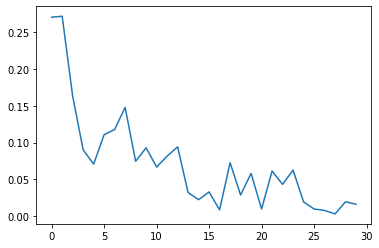

In [34]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')
plt.plot(loss_arr)
plt.show()

In [ ]:
# 이미지 자체 분석을 위한 모델이 아니기 때문에 튀긴하지만 loss가 낮아지는 것을 볼 수 있음